# **Emotion Classification Project**

The aim of this project is to develop an Emotion Classification model to detect emotions in queries and comments on our platform. The primary objective is to identify emotions, including joy, anger, surprise, sadness, disgust, and neutral emotions. While these emotions are our primary focus, we also explore the possibility of detecting sarcasm and dealing with multilingual content.

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [3]:
from io import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
!pip install fasttext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=f7cf14770ceccd586dc2409da9a62733a4ad337e1faef6a0887768faa3f03786
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [8]:
import fasttext
import pickle

In [33]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

**Data Source:**

Collected a publicly available dataset from [source], which contains user comments and labels for emotions.

In [34]:
# Read data
train = pd.read_csv("/content/drive/MyDrive/train.txt",delimiter=';',header=None,names=['sentence','label'])
test = pd.read_csv("/content/drive/MyDrive/test.txt",delimiter=';',header=None,names=['sentence','label'])

In [35]:
df = pd.concat([train,test])
print(df.shape)
df.head()

(18000, 2)


,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [37]:
print(df['label'].value_counts())
print('\n')
print(df['label'].value_counts(normalize=True))

joy         6057
sadness     5247
anger       2434
fear        2161
love        1463
surprise     638
Name: label, dtype: int64


joy         0.336500
sadness     0.291500
anger       0.135222
fear        0.120056
love        0.081278
surprise    0.035444
Name: label, dtype: float64


In [38]:
print(train.shape)
print(train['label'].value_counts(normalize=True))

(16000, 2)
joy         0.335125
sadness     0.291625
anger       0.134937
fear        0.121063
love        0.081500
surprise    0.035750
Name: label, dtype: float64


In [39]:
print(test.shape)
print(test['label'].value_counts(normalize=True))

(2000, 2)
joy         0.3475
sadness     0.2905
anger       0.1375
fear        0.1120
love        0.0795
surprise    0.0330
Name: label, dtype: float64


**Preprocess Text**

**Data Preprocessing:**

Data cleaning involved removing noise, handling missing values, and ensuring consistent formatting.
Text data was tokenized and stopwords were removed.

In [46]:
import pandas as pd
from nltk.corpus import stopwords

def clean_data(data):
    stop_words = set(stopwords.words('english'))

    # Create a new DataFrame to avoid modifying the original data
    new_data = pd.DataFrame({'sentence': data['sentence'], 'label': data['label']})

    # Clean the 'sentence' column
    new_data['sentence'] = new_data['sentence'].apply(lambda sentence: ' '.join(w.lower() for w in sentence.split() if (w.lower() not in stop_words) and w.isalpha()))

    # Remove rows with empty 'sentence' values
    new_data = new_data[new_data['sentence'] != '']

    # Reset the index
    new_data = new_data.reset_index(drop=True)

    return new_data


In [47]:
def extract_features(train_set, test_set, ngram):

    tfidf=TfidfVectorizer(use_idf=True, max_df=0.95, ngram_range=ngram)
    tfidf.fit_transform(train_set['sentence'].values)

    train_tfidf=tfidf.transform(train_set['sentence'].values)
    test_tfidf=tfidf.transform(test_set['sentence'].values)

    return train_tfidf,test_tfidf,tfidf

In [48]:
df_clean = clean_data(df)
df_clean.to_csv('/content/drive/MyDrive/data_clean.csv')

training_df, testing_df = train_test_split(df_clean[['sentence', 'label']].dropna(),
                                               test_size = 0.2, random_state = 2020)

X_train, X_test, tfidf_vectorizer = extract_features(training_df, testing_df, (1,2))
y_train = training_df['label'].values
y_test = testing_df['label'].values

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [49]:
np.mean([len(i) for i in df_clean.sentence])

61.62005555555555

**FIT MODELS**

We explored various model options, including:
*   Logistic Regression
*   SVM
*   Fasttext






LOGISTIC REGRESSION

Logistic Regression:
*   We used Logistic Regression as a simple baseline model for emotion classification.
*   Feature vectors were created using TF-IDF (Term Frequency-Inverse Document Frequency) representation.



In [50]:
def predict_evaluate(model, test_tfidf, test_y):
    prediction = model.predict(test_tfidf)
    print(classification_report(test_y, prediction))
    return prediction

In [ ]:
lr1 = LogisticRegression(random_state=2020, C=15, penalty='l2', max_iter=1000, verbose=1)
lr1_classifier = OneVsRestClassifier(lr1)
model_lr1 = lr1_classifier.fit(X_train,y_train)

lr1_pred = predict_evaluate(model_lr1, X_test, y_test)
#print('Accuracy:', accuracy_score(Y_test, Y_pred))
#print('F1-score:', f1_score(Y_test, Y_pred, average='micro'))

In [52]:
lr2 = LogisticRegression(random_state=2020, C=5, penalty='l2', max_iter=1000, verbose=1)
lr2_classifier = OneVsRestClassifier(lr2)
model_lr2 = lr2_classifier.fit(X_train,y_train)

lr2_pred = predict_evaluate(model_lr2, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.85      0.88       509
        fear       0.88      0.82      0.85       438
         joy       0.88      0.95      0.91      1220
        love       0.85      0.69      0.77       280
     sadness       0.91      0.97      0.94      1025
    surprise       0.85      0.62      0.71       128

    accuracy                           0.89      3600
   macro avg       0.88      0.82      0.84      3600
weighted avg       0.89      0.89      0.89      3600



In [53]:
lr3 = LogisticRegression(random_state=2020, C=30, penalty='l2', max_iter=1000, verbose=1)
lr3_classifier = OneVsRestClassifier(lr3)
model_lr3 = lr3_classifier.fit(X_train,y_train)

lr3_pred = predict_evaluate(model_lr3, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.93      0.89      0.91       509
        fear       0.89      0.84      0.87       438
         joy       0.90      0.94      0.92      1220
        love       0.83      0.73      0.78       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.81      0.67      0.74       128

    accuracy                           0.90      3600
   macro avg       0.88      0.84      0.86      3600
weighted avg       0.90      0.90      0.90      3600



In [54]:
filepath = "logistic_best.pkl"
with open(filepath, 'wb') as file:
    pickle.dump(model_lr3, file)

SVM

Support Vector Machine (SVM):
*   We implemented SVM, a versatile classification algorithm, for emotion classification.
*   Feature vectors were generated using TF-IDF encoding, similar to the Logistic Regression approach.



In [55]:
svm1 = LinearSVC(random_state=2020, C=1, loss='squared_hinge', max_iter=1000)
model_svm1 = svm1.fit(X_train,y_train)

svm1_pred = predict_evaluate(model_svm1, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.89      0.90       509
        fear       0.89      0.85      0.87       438
         joy       0.91      0.94      0.93      1220
        love       0.83      0.76      0.79       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.83      0.70      0.76       128

    accuracy                           0.91      3600
   macro avg       0.88      0.85      0.87      3600
weighted avg       0.90      0.91      0.90      3600



In [56]:
svm2 = LinearSVC(random_state=2020, C=50, loss='squared_hinge', max_iter=1000)
model_svm2 = svm2.fit(X_train,y_train)

svm2_pred = predict_evaluate(model_svm2, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.89      0.90       509
        fear       0.90      0.85      0.87       438
         joy       0.92      0.94      0.93      1220
        love       0.83      0.78      0.80       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.78      0.73      0.76       128

    accuracy                           0.91      3600
   macro avg       0.88      0.86      0.87      3600
weighted avg       0.91      0.91      0.91      3600



In [57]:
svm3 = LinearSVC(random_state=2020, C=50, loss='hinge', max_iter=1000)
model_svm3 = svm3.fit(X_train,y_train)

svm3_pred = predict_evaluate(model_svm3, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.89      0.90       509
        fear       0.90      0.84      0.87       438
         joy       0.92      0.94      0.93      1220
        love       0.82      0.78      0.80       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.80      0.73      0.76       128

    accuracy                           0.91      3600
   macro avg       0.88      0.86      0.87      3600
weighted avg       0.90      0.91      0.90      3600



In [58]:
svm4 = LinearSVC(random_state=2020, C=1, loss='hinge', max_iter=1000)
model_svm4 = svm4.fit(X_train,y_train)

svm4_pred = predict_evaluate(model_svm4, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.90      0.91       509
        fear       0.88      0.85      0.86       438
         joy       0.92      0.94      0.93      1220
        love       0.83      0.75      0.79       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.84      0.65      0.73       128

    accuracy                           0.91      3600
   macro avg       0.88      0.84      0.86      3600
weighted avg       0.90      0.91      0.90      3600



In [59]:
filepath = "svm_best.pkl"
with open(filepath, 'wb') as file:
    pickle.dump(model_svm2, file)

In [61]:
import matplotlib.pyplot as plt

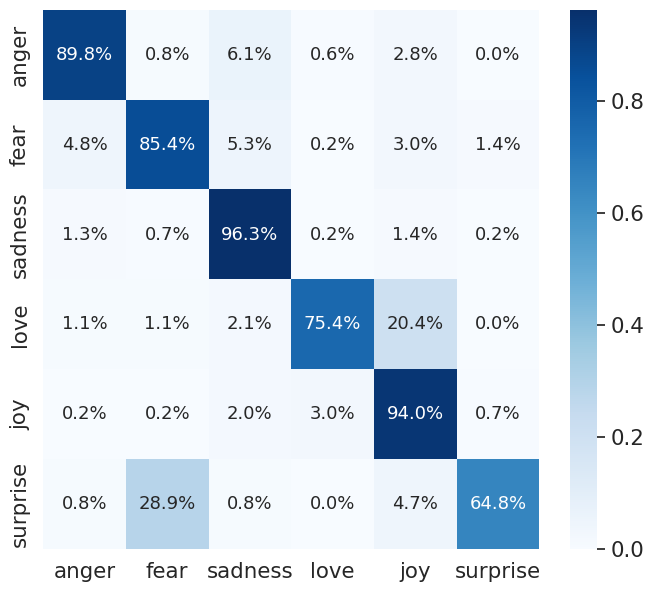

In [62]:
# confusion matrix
plt.figure(figsize=(8,7))
df_cm = pd.DataFrame(confusion_matrix(y_test, svm4_pred,
                                      labels=["anger", "fear","sadness", "love", "joy","surprise"]),
                    ["anger", "fear","sadness", "love", "joy","surprise"],
                    ["anger", "fear","sadness", "love", "joy","surprise"])
sns.set(font_scale=1.4)#for label size
# sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap="Blues")
sns.heatmap(df_cm.div(df_cm.sum(axis=1), axis=0), annot=True,
            fmt='.1%', cmap='Blues',annot_kws={"size": 13})
plt.show()

In [63]:
df_cm

,anger,fear,sadness,love,joy,surprise
anger,457,4,31,3,14,0
fear,21,374,23,1,13,6
sadness,13,7,987,2,14,2
love,3,3,6,211,57,0
joy,3,2,24,36,1147,8
surprise,1,37,1,0,6,83


In [64]:
testing_df[(y_test=='surprise') & (svm4_pred=='joy')]

,sentence,label
3258,feel like amazing co screenwriter roberto orci...,surprise
7511,feel urgency introduce readers amazing touchin...,surprise
7487,im feeling amazing im answering questions new ...,surprise
5400,chose makes feel amazing,surprise
4694,could picture homely feel also smell books wou...,surprise
4376,love sunshine havent much feeling shoulders wa...,surprise


In [65]:
list(df.loc[7511])

['i feel an urgency to introduce readers to the amazing and touching story of anna iya and erik',
 'surprise']

Fasttext

FastText:




*   We employed the FastText library, which is known for its efficiency in handling text data.
*   FastText was trained on the text data to learn word embeddings and perform classification.



In [66]:
# Format the data
train_fasttext = training_df.apply(lambda t: '__label__' + str(t['label']) +
                                   ' ' + str(t['sentence']), axis=1)
test_fasttext = testing_df.apply(lambda t: '__label__' + str(t['label']) +
                                 ' ' + str(t['sentence']), axis=1)
train_fasttext.to_csv('train_fasttext.txt',index=False, header=False)
test_fasttext.to_csv('test_fasttext.txt',index=False, header=False)

In [67]:
model_ft1 = fasttext.train_supervised('train_fasttext.txt', loss='softmax',
                                      lr=0.1, ws=5, wordNgrams=2, epoch=100)
ft1_pred = model_ft1.test('test_fasttext.txt')

print("precision: ", ft1_pred[1])
print("recall: ", ft1_pred[2])
print("F-1 score: ", 2*ft1_pred[1]*ft1_pred[2]/(ft1_pred[1]+ft1_pred[2]))

precision:  0.8925
recall:  0.8925
F-1 score:  0.8925


In [68]:
model_ft12 = fasttext.train_supervised('train_fasttext.txt', loss='softmax',
                                      lr=0.2, ws=10, wordNgrams=2, epoch=100)
ft2_pred = model_ft12.test('test_fasttext.txt')

print("precision: ", ft2_pred[1])
print("recall: ", ft2_pred[2])
print("F-1 score: ", 2*ft2_pred[1]*ft2_pred[2]/(ft2_pred[1]+ft2_pred[2]))

precision:  0.8941666666666667
recall:  0.8941666666666667
F-1 score:  0.8941666666666667


In [69]:
model_ft13 = fasttext.train_supervised('train_fasttext.txt', loss='softmax',
                                      lr=0.2, ws=10, wordNgrams=2, epoch=300)
ft3_pred = model_ft13.test('test_fasttext.txt')

print("precision: ", ft3_pred[1])
print("recall: ", ft3_pred[2])
print("F-1 score: ", 2*ft3_pred[1]*ft3_pred[2]/(ft3_pred[1]+ft3_pred[2]))

precision:  0.8933333333333333
recall:  0.8933333333333333
F-1 score:  0.8933333333333333


In [70]:
model_ft14 = fasttext.train_supervised('train_fasttext.txt', loss='softmax',
                                      lr=0.2, ws=15, wordNgrams=2, epoch=100)
ft4_pred = model_ft14.test('test_fasttext.txt')
ft4_pred
print("precision: ", ft4_pred[1])
print("recall: ", ft4_pred[2])
print("F-1 score: ", 2*ft4_pred[1]*ft4_pred[2]/(ft4_pred[1]+ft4_pred[2]))

precision:  0.8941666666666667
recall:  0.8941666666666667
F-1 score:  0.8941666666666667
